In the [2018 Data Sciene Bowl](https://www.kaggle.com/c/data-science-bowl-2018), a Kaggle competition, the competitors were provided with microscopic images of nuclei and were tasked to identify them. In this notebook, we will explore the data and experiment a baseline model.

Thanks Kjetil Åmdal-Sævik for [his notebook](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) and Raoul Malm for [his](https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352).

# 0. Prelimitary

In [ ]:
import numpy as np
import random

random.seed()
np.random.seed()

TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

# 1. Data Exploration

## 1.1 Load Data

In [1]:
from project_utils import load_train_set

train = load_train_set(TRAIN_PATH)

Loading images...


100%|██████████| 670/670 [00:02<00:00, 291.65it/s]


Loading masks...


100%|██████████| 670/670 [00:20<00:00, 32.63it/s]


In [2]:
from project_utils import load_test_set

test = load_test_set(TEST_PATH)

Loading images...


100%|██████████| 65/65 [00:00<00:00, 251.15it/s]


## 1.2 Sample Data

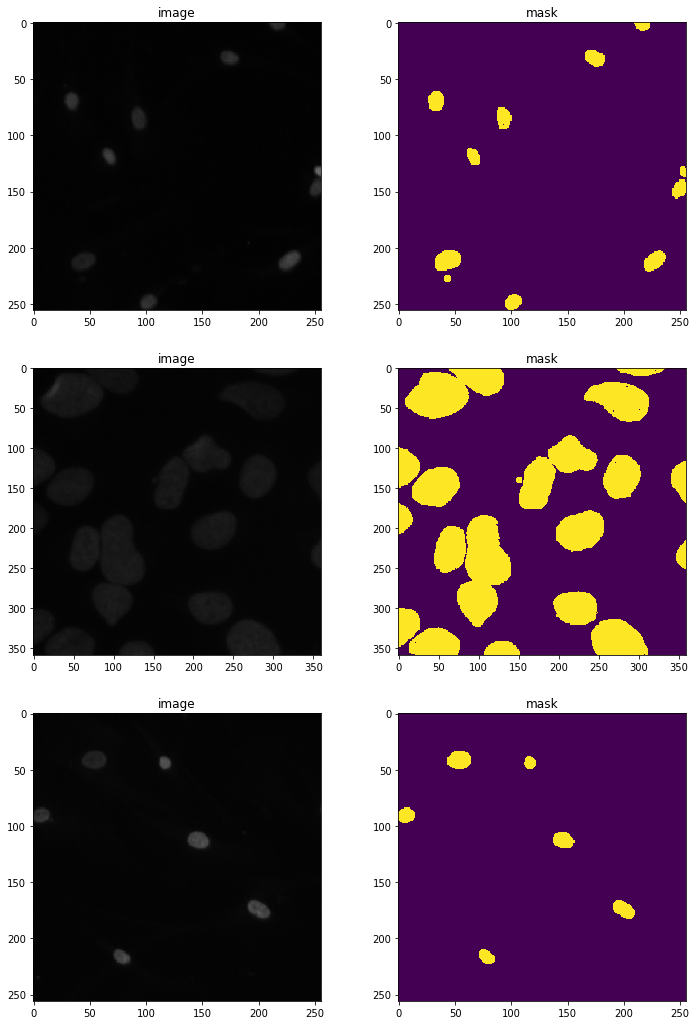

In [3]:
from project_utils import compare_images

compare_images(train['image'], train['mask'], title1='image', title2='mask')

It is noteworthy that some nuclei in the border region are cropped. It is possible that this would confuse the model. Padding, by mirroing or other ways, might help.

## 1.3 Image Dimension
The images have different dimension. Before we decide how to handle it, first let's take a look at the statstic.

### 1.3.1 Train set

In [4]:
from project_utils import get_dim_stat

train_dim_stat = get_dim_stat(train['image'])
train_dim_stat.describe()

,height,width,h/w ratio,channel count
count,670.000000,670.000000,670.000000,670.0
mean,333.991045,378.500000,0.921008,4.0
std,149.474845,204.838693,0.114294,0.0
min,256.000000,256.000000,0.474057,4.0
25%,256.000000,256.000000,0.800000,4.0
50%,256.000000,320.000000,1.000000,4.0
75%,360.000000,360.000000,1.000000,4.0
max,1040.000000,1388.000000,1.000000,4.0


### 1.3.2 Test set

In [5]:
test_dim_stat = get_dim_stat(test['image'])
test_dim_stat.describe()

,height,width,h/w ratio,channel count
count,65.000000,65.000000,65.000000,65.000000
mean,402.676923,393.184615,1.186171,3.569231
std,129.082956,189.813386,0.631035,0.499038
min,256.000000,161.000000,0.747126,3.000000
25%,256.000000,256.000000,0.800000,3.000000
50%,512.000000,256.000000,1.000000,4.000000
75%,519.000000,640.000000,1.494253,4.000000
max,524.000000,696.000000,3.223602,4.000000


### 1.3.3 Insight
It appears that most samples, from both the train set and the test set, are 256x256. Most of those that are not are larger, with only a few exceptions in the test set. It should not be a problem to scale these larger ones down. The height/width ratio could be a problem, however. Some images from the test set have extremely uneven height and width, so resizing them to a square shape would significantly deform the image. It is unclear to me at this point how much would it affect the performance.   

# 2. Preprocessing

## 2.1 Generalization
In order to be used as input for the model, the images must have the same size. There might be better methods, but at this stage we will simply resize the images to have 256x256 pixels. 
Many of the images are black and white whereas some are colored. We assume that color should not play any role in the detection process, and standardize the images by converting them all to grayscale.

In [6]:
from project_utils import standardize_images

IMAGE_DIM = (256, 256)

X = standardize_images(train['image'], shape=IMAGE_DIM, grayscale=True)
Y = standardize_images(train['mask'], shape=IMAGE_DIM, grayscale=True)
X_ = standardize_images(test['image'], shape=IMAGE_DIM, grayscale=True)

## 2.2 Data Augmentation
It is very common to use a convolutional neural network (CNN) for image data, and many studies have shown that CNNs is sensitive to the rotation, tilt, and other forms of deformation. To solve this problem, we could try adding transformed copies of the images to the train set.  

In [7]:
from project_utils import augment_data

X, Y = augment_data(X, Y, rotate=True)
print("%d samples added (total %d)" % (X.shape[0]-train.shape[0], X.shape[0]))

670 samples added (total 1340)


# 3. Model

## 3.1 Evaluation Metric
The competition evaluates a submission by calculating the average of intersection over union (IoU) with different threshold (0.5 to 0.95, with a step size of 0.05). Keras does not support this as evaluation metric; TensorFlow supports mean IoU metric but not over multiple thresholds; therefore, we need to write our own.

In [8]:
import keras.backend as K
import tensorflow as tf


# This method does not work because the tensorflow.metrics.mean_iou
# incorrectly counts background. For now, use accuracy instead.

# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 4. Model
Using the model from [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf).

## 4.1 Settings and Builders

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D

CONV_BASE_SIZE = 16
CONV_KERNEL = (3, 3)
TRAN_KERNEL = (3, 3)
CONV_ACTIVATION = 'relu'
CONV_PADDING = 'same'
CONV_KERNEL_INIT = 'glorot_normal'
CONV_DROPOUT = 0.2
POOLING_SIZE = (2, 2)


def build_conv_layer(filter_size):
    """
    build a convolution layer using the preset hyperparameters
    """
    return Conv2D(
        filter_size, 
        kernel_size=CONV_KERNEL,
        padding=CONV_PADDING,
        activation=CONV_ACTIVATION,
        kernel_initializer=CONV_KERNEL_INIT
    )

def build_conv_block(connect, depth):
    """
    build a 2-convolutional-layer block
    """
    filter_size = CONV_BASE_SIZE*(2**depth)
    x = build_conv_layer(filter_size)(connect)
    x = Dropout(CONV_DROPOUT)(x)
    x = build_conv_layer(filter_size)(x)
    return x

def build_upsample_block(connect, merge, depth):
    """
    build a upsampling block
    """
    filter_size = CONV_BASE_SIZE*(2**depth)
    x = Conv2DTranspose(
        filter_size, 
        TRAN_KERNEL, 
        strides=POOLING_SIZE, 
        padding=CONV_PADDING
    )(connect)
    return concatenate([x, merge])

## 4.2 Model Definition

In [13]:
# input layer
inputs = Input((IMAGE_DIM + (1,)))

# downsampling layers (left of the U)
down_conv_0 = build_conv_block(inputs, depth=0)
down_pool_0 = MaxPooling2D(POOLING_SIZE)(down_conv_0)
down_conv_1 = build_conv_block(down_pool_0, depth=1)
down_pool_1 = MaxPooling2D(POOLING_SIZE)(down_conv_1)
down_conv_2 = build_conv_block(down_pool_1, depth=2)
down_pool_2 = MaxPooling2D(POOLING_SIZE)(down_conv_2)
down_conv_3 = build_conv_block(down_pool_2, depth=3)
down_pool_3 = MaxPooling2D(POOLING_SIZE)(down_conv_3)

# bottom layer
#conv_bottom = build_conv_block(down_pool_2, depth=3)
conv_bottom = build_conv_block(down_pool_3, depth=4)

# upsampling layers (right of the U)
upsample_3 = build_upsample_block(conv_bottom, down_conv_3, 3)
up_conv_3 = build_conv_block(upsample_3, depth=3)
upsample_2= build_upsample_block(up_conv_3, down_conv_2, 2)
#upsample_2= build_upsample_block(conv_bottom, down_conv_2, 2)
up_conv_2= build_conv_block(upsample_2, depth=3)
upsample_1= build_upsample_block(up_conv_2, down_conv_1, 1)
up_conv_1= build_conv_block(upsample_1, depth=3)
upsample_0= build_upsample_block(up_conv_1, down_conv_0, 0)
up_conv_0= build_conv_block(upsample_0, depth=3)

# output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(up_conv_0)

# compile
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 2320        dropout_10[0][0]                 
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 128 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 128 147584      dropout_18[0][0]                 
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 1)  129         conv2d_37[0][0]                  
Total params: 2,746,593
Trainable params: 2,746,593
Non-trainable params: 0
__________________________________________________________________________________________________


## 4.3 Training

In [14]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

BATCH_SIZE = 16
EPOCHS = 50
VALIDATION_SIZE = 0.1
STOPPER = [
    EarlyStopping(monitor='val_loss', patience=3),
    EarlyStopping(monitor='loss'),
]

Xtr, Xva, Ytr, Yva = train_test_split(X, Y, test_size=VALIDATION_SIZE)

model.fit(
    Xtr, Ytr, 
    validation_data=(Xva, Yva),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=STOPPER,
    verbose=2
)

Train on 1206 samples, validate on 134 samples
Epoch 1/50
 - 26s - loss: 0.3342 - acc: 0.8499 - val_loss: 0.2315 - val_acc: 0.8379
Epoch 2/50
 - 25s - loss: 0.1838 - acc: 0.9060 - val_loss: 0.1879 - val_acc: 0.9077
Epoch 3/50
 - 25s - loss: 0.1371 - acc: 0.9350 - val_loss: 0.1496 - val_acc: 0.9233
Epoch 4/50
 - 25s - loss: 0.1243 - acc: 0.9408 - val_loss: 0.1262 - val_acc: 0.9378
Epoch 5/50
 - 26s - loss: 0.1076 - acc: 0.9465 - val_loss: 0.1064 - val_acc: 0.9455
Epoch 6/50
 - 26s - loss: 0.0939 - acc: 0.9522 - val_loss: 0.0966 - val_acc: 0.9506
Epoch 7/50
 - 26s - loss: 0.0902 - acc: 0.9538 - val_loss: 0.0922 - val_acc: 0.9514
Epoch 8/50
 - 25s - loss: 0.0849 - acc: 0.9555 - val_loss: 0.0866 - val_acc: 0.9545
Epoch 9/50
 - 26s - loss: 0.0819 - acc: 0.9565 - val_loss: 0.0849 - val_acc: 0.9542
Epoch 10/50
 - 26s - loss: 0.0792 - acc: 0.9579 - val_loss: 0.0802 - val_acc: 0.9567
Epoch 11/50
 - 26s - loss: 0.0768 - acc: 0.9586 - val_loss: 0.0884 - val_acc: 0.9543
Epoch 12/50
 - 26s - loss: 

# 5. Submission